In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math

def log_prob_loss(output, y_target): 
    mean, std = output.chunk(2, dim=-1)
    std = F.softplus(std)
    dist = D.Normal(loc=mean, scale=std)
    return -torch.mean(dist.log_prob(y_target)) 

class CNMP(nn.Module):
    def __init__(self, d_x, d_y, d_SM):
        super(CNMP, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(d_x + d_y, 64), nn.LayerNorm(64), nn.ReLU(),
            nn.Linear(64, 64), nn.LayerNorm(64), nn.ReLU(),
            nn.Linear(64, 128), nn.LayerNorm(128), nn.ReLU(),
            nn.Linear(128, 128), nn.LayerNorm(128), nn.ReLU(),
            nn.Linear(128, 256), nn.LayerNorm(256), nn.ReLU(),
            nn.Linear(256, 256),
        )

        self.decoder = nn.Sequential(
            nn.Linear(d_x + (12) + 256, 1024), nn.LayerNorm(1024), nn.ReLU(),
            nn.Linear(1024, 512), nn.LayerNorm(512), nn.ReLU(),
            nn.Linear(512, 256), nn.LayerNorm(256), nn.ReLU(),
            nn.Linear(256, 128), nn.LayerNorm(128), nn.ReLU(),
            nn.Linear(128, 64), nn.LayerNorm(64), nn.ReLU(),
            nn.Linear(64, 2 * d_SM)  # Output mean and std for
        )
    def forward(self, obs, context, mask, x_tar): # obs is (n, d_x + d_y)

        r = self.encoder(obs)
        masked_r = torch.bmm(mask, r)
        masked_r_sum = torch.sum(masked_r, dim=1, keepdim=True)  # (1, 128)
        r_avg = masked_r_sum / torch.sum(mask, dim=[1,2], keepdim=True)  # (1, 128)
        r_avg = r_avg.repeat(1, x_tar.shape[1], 1)
        context = context.unsqueeze(1).repeat(1, x_tar.shape[1], 1)  # (n, 1, 9)
        concat = torch.cat((r_avg, context, x_tar), dim=-1)
        #concat = torch.cat((r_avg, x_tar), dim=-1)
        output = self.decoder(concat) # (2*d_y,)
        return output, r_avg

# gets random number of random obs. points from a random trajectory. Also gets a 
# random target (x,y) from the same trajectory
def get_training_sample(d_SM, batch_size):

    n = np.random.randint(0, OBS_MAX, batch_size) + 1  # number of observations
    perm = np.random.permutation(d_N)
    d = perm[:batch_size]  # select random trajectories

    observations = np.zeros((batch_size, OBS_MAX, d_x + d_y))
    context = np.zeros((batch_size, 12))
    target_X = np.zeros((batch_size, 1, d_x))
    target_Y = np.zeros((batch_size, 1, d_SM))
    mask = np.zeros((batch_size, OBS_MAX, OBS_MAX))

    for i in range(batch_size):
        perm = np.random.permutation(time_len)
        observations[i,:n[i],:d_x] = X[d[i],perm[:n[i]]]
        observations[i,:n[i],d_x:d_x+d_y] = Y[d[i],perm[:n[i]]]
        #context[i,:] = np.concat((C[d[i]], O[d[i], perm[n[i]]]), axis=-1)
        context[i,:] = C[d[i]]
        target_X[i,0] = X[d[i],perm[n[i]]]
        target_Y[i,0] = Y[d[i],perm[n[i]],:d_SM]
        mask[i,:n[i],:n[i]] = 1
    
    return torch.from_numpy(observations), torch.from_numpy(context), \
            torch.from_numpy(target_X), torch.from_numpy(target_Y), torch.from_numpy(mask)

In [ ]:
import validation
import importlib
importlib.reload(validation)

time_len = 200
X = np.tile(np.linspace(0, 1, time_len).reshape((1, time_len, 1)), (25, 1, 1))  # 25 trajectories
action_data = np.load('new_action_trajectories.npy')  # shape (25, 200, 30)
observation_data = np.load('new_observation_trajectories.npy')  # shape (25, 200, 30)
context_data = np.load('new_diff_context.npy')  # shape (25, 9)

print("Data shape:", action_data.shape, context_data.shape)

Y = np.zeros((25, time_len, 30))
C = np.zeros((25, 12))
for i in range(25):
    Y[i] = action_data[i]  
    O[i] = observation_data[i]  
    C[i] = context_data[i]

OBS_MAX = 5
d_x = X.shape[-1]
d_y = Y.shape[-1]
d_SM = d_y
d_N = Y.shape[0]
batch_size = 8

model = CNMP(d_x, d_y, d_SM).double()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []
errors = []

val_indices = [0, 1]

for i in range(500000):

    obs, context, x_tar, y_tar, mask = get_training_sample(d_SM, batch_size)

    optimizer.zero_grad()

    output, _ = model(obs, context, mask, x_tar)
    loss = log_prob_loss(output, y_tar)
    
    loss.backward()
    optimizer.step()

    if i % 10000 == 0:
        print('Iteration ' + str(i))
    if i % 2000 == 0:
        #epoch_error = validation.val(model, VAL_Y, VAL_C, d_x, d_y, d_SM)
        #errors.append(epoch_error)
        losses.append(loss.item())
        if min(losses) == loss.item():
            print('Iteration ' + str(i) + ' - Loss: ' + '%.4f' % loss.item())
            print('Saving model...')
            torch.save(model.state_dict(), 'best_model_newdataset_diff_hierarch.pth')

torch.Size([1, 1, 31])
torch.Size([1, 1, 31])
torch.Size([1, 1, 31])
torch.Size([1, 1, 31])


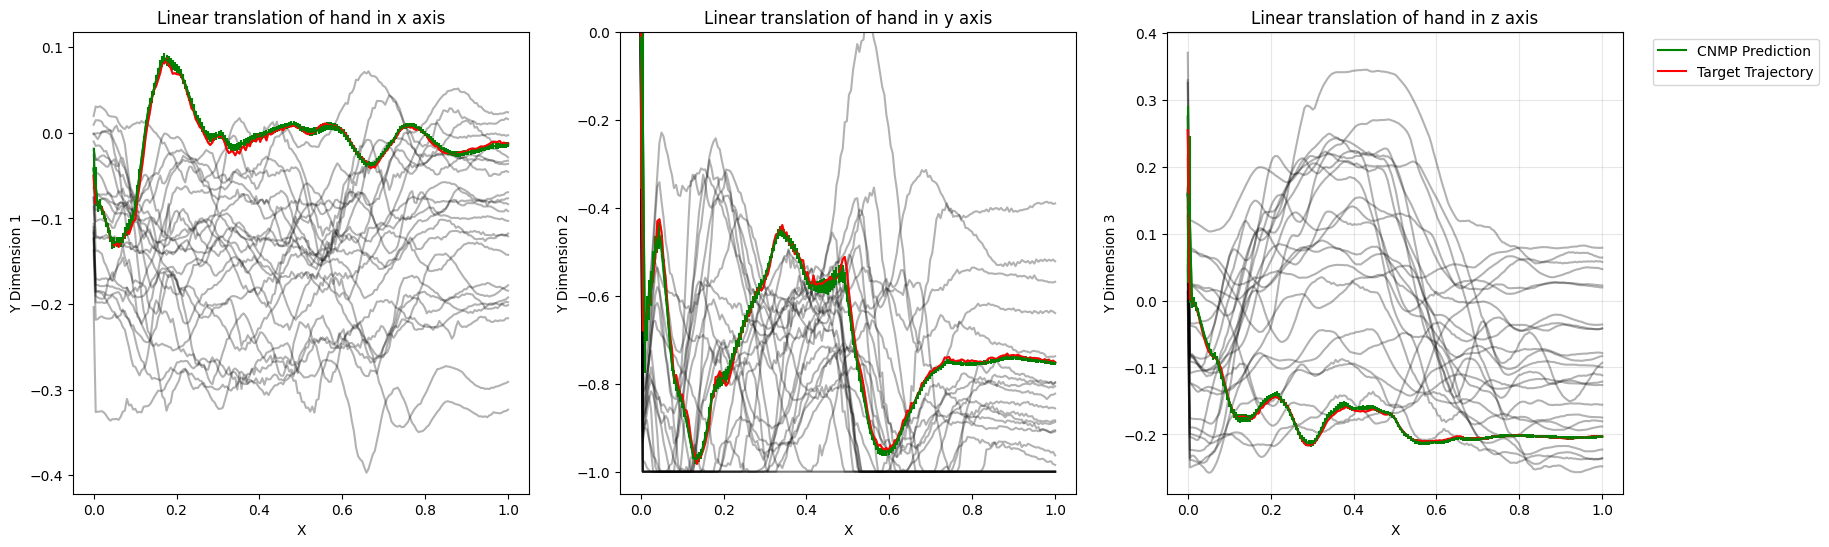

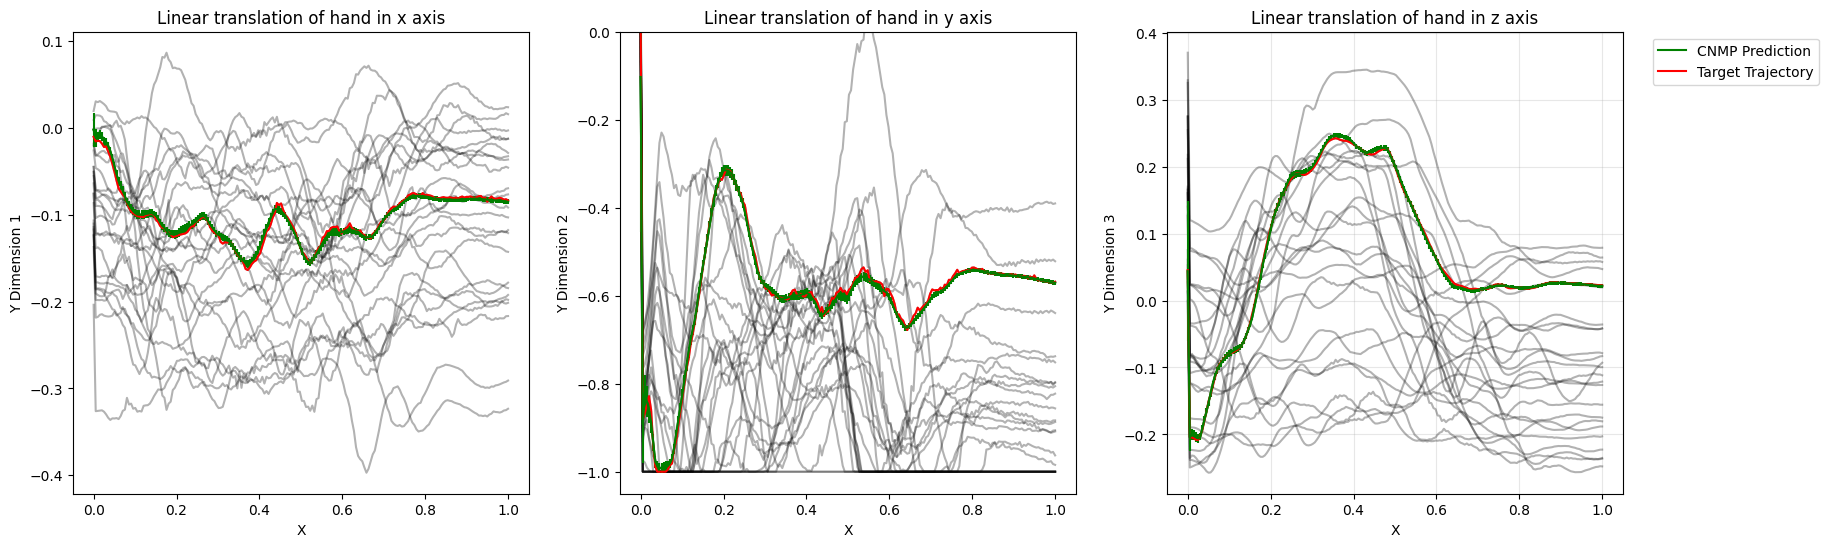

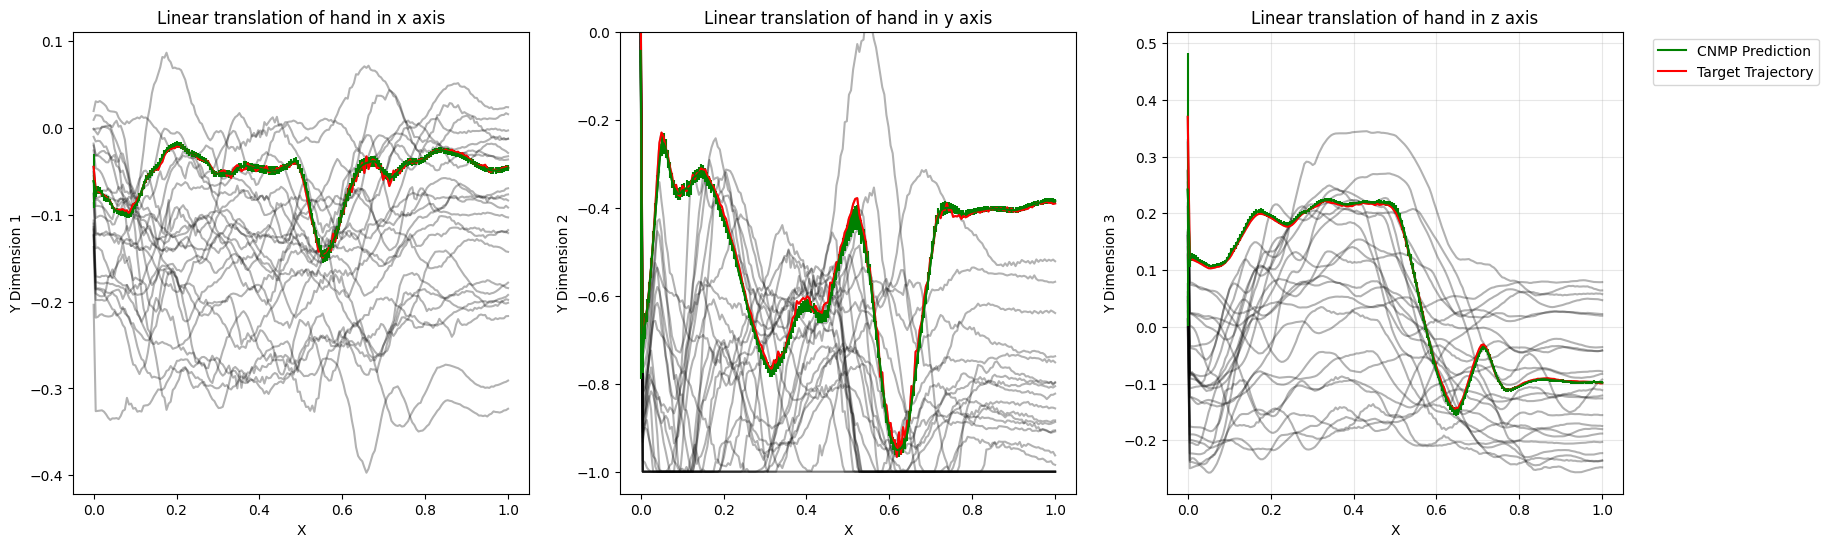

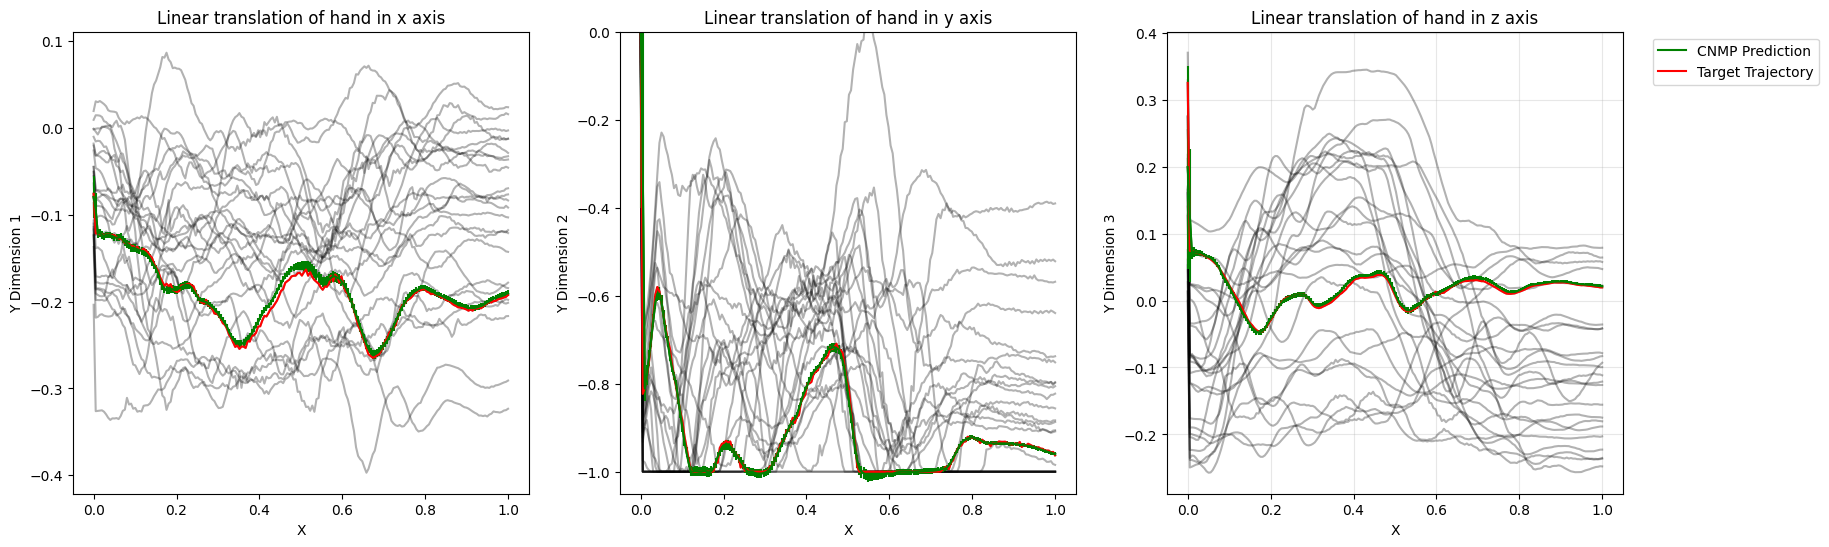

In [96]:
def generate_trajectory(model, obs, context):
    obs = torch.tensor(obs, dtype=torch.float64).unsqueeze(0)  # (1, 1, d_x + d_y)
    print(obs.shape)
    mask = torch.ones((1, obs.shape[1], obs.shape[1]), dtype=torch.float64)
    context = torch.tensor(context, dtype=torch.float64).unsqueeze(0)  # (1, 9)
    x_tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1)
    with torch.no_grad():
        output, _ = model(obs, context, mask, x_tar)
    mean, std = output.chunk(2, dim=-1)
    std = F.softplus(std)
    return mean, std

def generate_trajectory_temp(model, obs, context, idx):
    obs = torch.tensor(obs, dtype=torch.float64).unsqueeze(0)  # (1, 1, d_x + d_y)
    print(obs.shape)
    mask = torch.ones((1, obs.shape[1], obs.shape[1]), dtype=torch.float64)
    context = torch.tensor(context, dtype=torch.float64).unsqueeze(0)  # (1, 9)
    x_tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1)
    output = torch.zeros((1, 200, 2* d_SM))
    with torch.no_grad():
        for i in range(200):
            context_temp = torch.concat((context, torch.tensor(O[idx, [i]])), axis=-1)  # context is (12 + 30,)
            output[0, i], _ = model(obs, context_temp, mask, x_tar[:, i:i+1, :])
    mean, std = output.chunk(2, dim=-1)
    std = F.softplus(std)
    return mean, std

best_model = CNMP(d_x, d_y, d_SM).double()
best_model.load_state_dict(torch.load('best_model_newdataset_diff_hierarch.pth'))
best_model.eval()

action_data = np.load('new_action_trajectories.npy')  # Load the Y values from the saved file
observation_data = np.load('new_observation_trajectories.npy')  # Load the X values from the saved file
context_data = np.load('new_diff_context.npy')  # Load the context data

Y = np.zeros((25, time_len, 30))
O = np.zeros((25, time_len, 30))
C = np.zeros((25, 12))
for i in range(25):
    Y[i] = action_data[i]
    O[i] = observation_data[i]
    C[i] = context_data[i]

for idx in [0, 1, 23, 24]:
    
    cnmp_obs = np.array([np.concat((X[0, 0, :], Y[idx, 0, :]), axis=-1)])
    context = C[idx]

    mean, std = generate_trajectory(best_model, cnmp_obs, context)
    plt.figure(figsize=(20, 6))
    ax1 = plt.subplot(1, 3, 1)
    ax2 = plt.subplot(1, 3, 2)
    ax3 = plt.subplot(1, 3, 3)
    axes = [ax1, ax2, ax3]
    titles = ['Linear translation of hand in x axis',
              'Linear translation of hand in y axis',
              'Linear translation of hand in z axis']
    for i in range(d_N):
        for dim in range(3):
            axes[dim].plot(X[i, :, 0], Y[i, :, dim], color='black', alpha=0.3)

    for dim in range(3):
        axes[dim].errorbar(X[0, :, 0], mean[0, :, dim].numpy(), yerr=std[0, :, dim].numpy(), 
                        color='green', alpha=1.0)
        axes[dim].plot(X[0, :, 0], mean[0, :, dim].numpy(), color='green', label='CNMP Prediction')
        axes[dim].plot(X[0, :, 0], Y[idx, :, dim], color='red', label='Target Trajectory')
        axes[dim].set_title(titles[dim])
        axes[dim].set_xlabel('X')
        axes[dim].set_ylabel(f'Y Dimension {dim + 1}')
    axes[dim].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[dim].grid(alpha=0.3)
    axes[1].set_ylim(-1.05, 0.0)
    plt.savefig(f'cnmp_prediction_{idx}_diff_hierarch.png', bbox_inches='tight')

In [13]:
Y = np.load('trajectories.npy')  # Load the Y values from the saved file

for i in range(1):
    print(f"Trajectory {i} with shape {Y[i, 0, :].shape}:")
    print(Y[i, 0, :39])
    print()
    print(Y[i, 0, 39:69])


Trajectory 0 with shape (69,):
[-0.08231702 -0.68285835  0.00235635  0.05805042  0.01188875  0.04079193
  0.68416882  0.08570135  0.00317908  0.04084618  0.17546849 -0.01331007
  0.29086339 -0.09457348 -0.00415219 -0.156221   -0.12354942 -0.50465071
  0.31163403  0.19562872  0.48245454 -0.5354386  -0.33205748  0.91070062
  0.40869677  0.72718602  0.650729    1.         -0.97681236  0.43658811
 -0.05009139  0.07742458  0.25464621  0.10962787  0.02768584  0.07719514
  0.          0.          0.        ]

[ 0.00000000e+00  5.55111512e-17  0.00000000e+00  0.00000000e+00
 -5.55111512e-17  5.55111512e-17  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.70288382e-01  2.15131006e-01  1.38808769e-01
 -1.42260382e-01  1.87988006e-01  1.42827673e-02  2.80280001e-02
 -2.71429997e-02 -1.24526002e-01]
